# Inspecting Data, Metrics and Calibration Solutions

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import hera_qm as hqm
import hera_cal as hc
import aipy
from pyuvdata import UVCal, UVData, UVFITS
import os
import sys
import glob
from memory_profiler import memory_usage as memuse
import uvtools as uvt
from collections import OrderedDict
from astropy.time import Time

## Setup Env Vars


In [2]:
# get data location
data_path = os.environ['DATA_PATH']
calfile = os.environ['CALFILE']

In [13]:
# get xx and yy files
file_index = 0
xxfiles = sorted(glob.glob("{0}/zen.*.*.xx.HH.uvc".format(data_path)))
yyfiles = sorted(glob.glob("{0}/zen.*.*.yy.HH.uvc".format(data_path)))

xxfile = xxfiles[file_index]
yyfile = yyfiles[file_index]

xxfile_bases = map(os.path.basename, xxfiles)
yyfile_bases = map(os.path.basename, yyfiles)

xxfile_base = os.path.basename(xxfile)
yyfile_base = os.path.basename(yyfile)

# Load data
uvd_xx = UVData()
uvd_xx.read_miriad(xxfile)
uvd_xx.ants = np.unique(np.concatenate([uvd_xx.ant_1_array, uvd_xx.ant_2_array]))
uvd_yy = UVData()
uvd_yy.read_miriad(yyfile)
uvd_yy.ants = np.unique(np.concatenate([uvd_yy.ant_1_array, uvd_yy.ant_2_array]))

# Get metadata
freqs = uvd_xx.freq_array.squeeze() / 1e6
times = uvd_xx.time_array.reshape(uvd_xx.Ntimes, uvd_xx.Nbls)[:, 0]
jd_start = np.floor(times.min())
Nfreqs = len(freqs)
Ntimes = len(times)

In [14]:
# get redundant info
aa = aipy.cal.get_aa(calfile, np.array([.150]))
info = hc.omni.aa_to_info(aa)
red_bls = np.array(info.get_reds())
ants = np.unique(np.concatenate(red_bls))
Nants = len(ants)
Nside = int(np.ceil(np.sqrt(Nants)))
Yside = int(np.ceil(float(Nants)/Nside))

## Autocorrelations

divide by zero encountered in log10
divide by zero encountered in log10


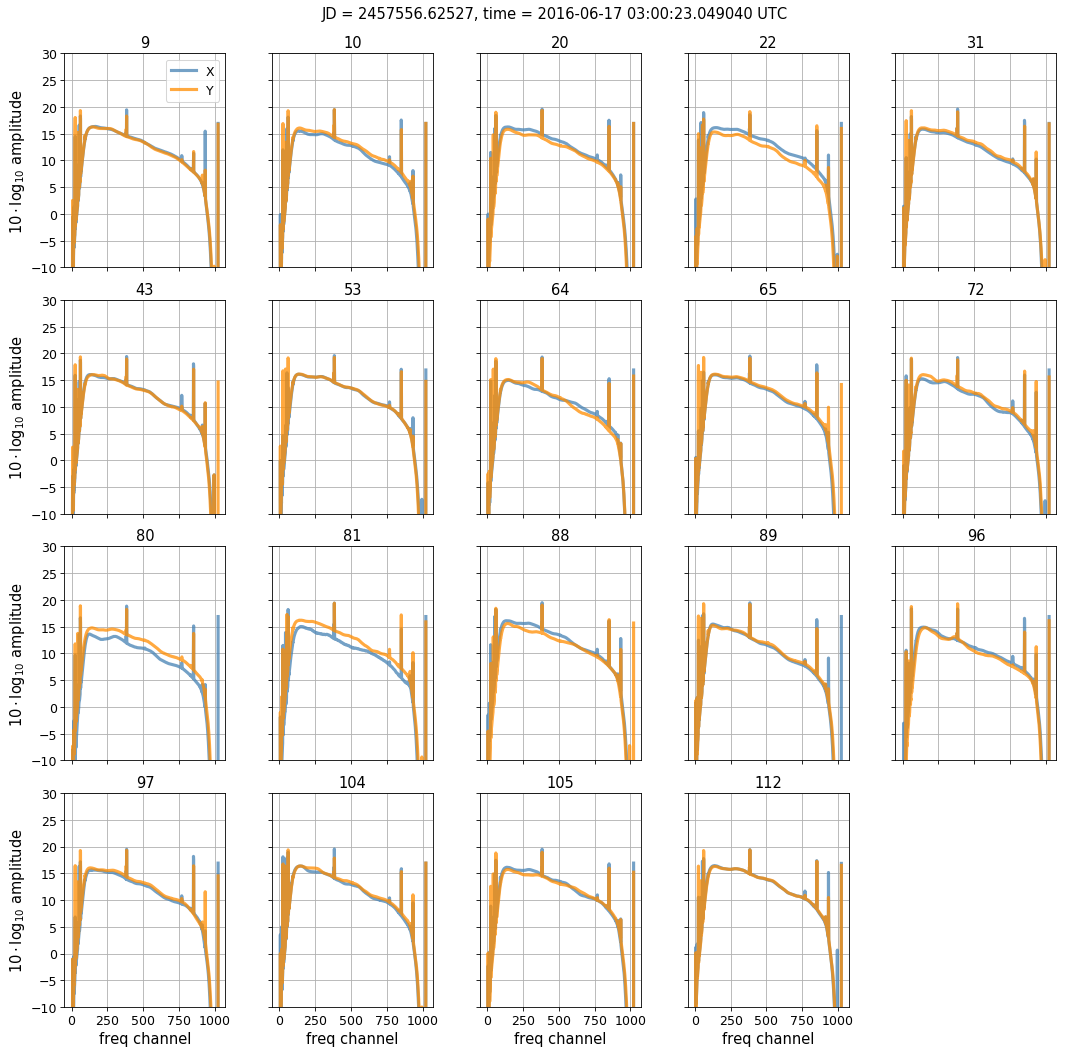

In [15]:
### plot autos
t_index = 0
jd = times[t_index]
utc = Time(jd, format='jd').datetime

xlim = (-50, Nfreqs+50)
ylim = (-10,30)

fig, axes = plt.subplots(Yside, Nside, figsize=(14,14), dpi=75)
fig.subplots_adjust(wspace=0.2, hspace=0.2)
fig.suptitle("JD = {0}, time = {1} UTC".format(jd, utc), fontsize=14)
fig.tight_layout(rect=(0, 0, 1, 0.95))

k = 0
for i in range(Yside):
    for j in range(Nside):
        ax = axes[i,j]
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        if k < Nants:
            px, = ax.plot(10*np.log10(np.abs(uvd_xx.get_data((ants[k], ants[k]))[t_index])), color='steelblue', alpha=0.75, linewidth=3)
            py, = ax.plot(10*np.log10(np.abs(uvd_yy.get_data((ants[k], ants[k]))[t_index])), color='darkorange', alpha=0.75, linewidth=3)
            ax.grid(True, which='both')
            ax.set_title(str(ants[k]), fontsize=14)
            if k == 0:
                ax.legend([px, py], ['X', 'Y'], fontsize=12)
        else:
            ax.axis('off')
        if j != 0:
            ax.set_yticklabels([])
        else:
            [t.set_fontsize(12) for t in ax.get_yticklabels()]
            ax.set_ylabel(r'$10\cdot\log_{10}$ amplitude', fontsize=14)
        if i != Yside-1:
            ax.set_xticklabels([])
        else:
            [t.set_fontsize(12) for t in ax.get_xticklabels()]
            ax.set_xlabel('freq channel', fontsize=14)

        k += 1

### Plot auto amplitude at a specific frequency over entire night

In [6]:
def timeseries_data(files, nu_index=500):
    amps = []
    times = []
    print "gather nightly data for JD = {0}".format(jd_start)
    Nfiles = len(files)
    for i, f in enumerate(files):
        uvd = UVData()
        uvd.read_miriad(f)
        amps.extend(np.array([uvd.get_data((a, a))[:, nu_index] for a in ants]).T)
        times.extend(uvd.time_array.reshape(uvd.Ntimes, uvd.Nbls)[:, 0])
        del uvd
    return np.array(amps).T, np.array(times)

nu_index = 500
amps_timeseries_xx, times_xx = timeseries_data(xxfiles, nu_index=nu_index)
amps_timeseries_yy, times_yy = timeseries_data(yyfiles, nu_index=nu_index)
times_xx = times_xx % 1
times_yy = times_yy % 1

gather nightly data for JD = 2457556.0
gather nightly data for JD = 2457556.0


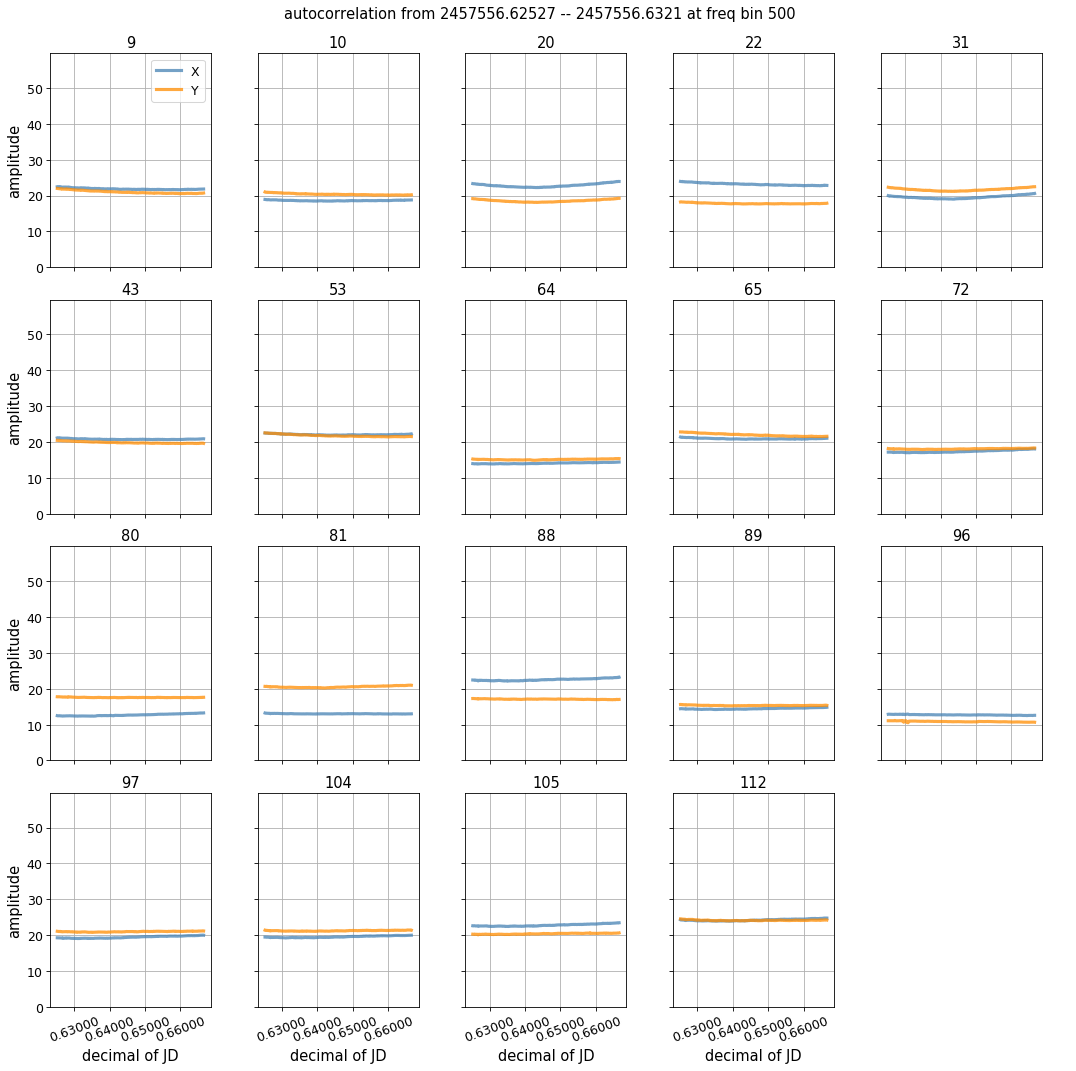

In [7]:
# plot autos
ylim = (0, np.median(np.abs(amps_timeseries_xx))*3)

fig, axes = plt.subplots(Yside, Nside, figsize=(14,14), dpi=75)
fig.subplots_adjust(wspace=0.2, hspace=0.2)
fig.suptitle("autocorrelation from {0} -- {1} at freq bin {2}".format(times[0], times[-1], nu_index), fontsize=14)
fig.tight_layout(rect=(0, 0, 1, 0.95))

k = 0
for i in range(Yside):
    for j in range(Nside):
        ax = axes[i,j]
        ax.set_ylim(ylim)
        if k < Nants:
            px, = ax.plot(times_xx, np.abs(amps_timeseries_xx[k]), color='steelblue', alpha=0.75, linewidth=3)
            py, = ax.plot(times_yy, np.abs(amps_timeseries_yy[k]), color='darkorange', alpha=0.75, linewidth=3)
            ax.grid(True)
            ax.set_title(str(ants[k]), fontsize=14)
            if k == 0:
                ax.legend([px, py], ['X', 'Y'], fontsize=12)
        else:
            ax.axis('off')
        if j != 0:
            ax.set_yticklabels([])
        else:
            [t.set_fontsize(12) for t in ax.get_yticklabels()]
            ax.set_ylabel('amplitude', fontsize=14)
        if i != Yside-1:
            ax.set_xticklabels([])
        else:
            [t.set_fontsize(12) for t in ax.get_xticklabels()]
            [t.set_rotation(20) for t in ax.get_xticklabels()]
            ax.xaxis.set_major_formatter(FormatStrFormatter('%.5f'))
            ax.set_xlabel('decimal of JD', fontsize=14)
        k += 1

## Ant Metrics

In [16]:
antfile = xxfile_base.split('.')
antfile.pop(3)
antfile = os.path.join(data_path, '.'.join(antfile) + '.ant_metrics.json')
ant_metrics = hqm.ant_metrics.load_antenna_metrics(antfile)

In [17]:
def plot_metric(metrics, ants=None, antpols=None, title='', ylabel='Modified z-Score', xlabel=''):
    '''Helper function for quickly plotting an individual antenna metric.'''

    if ants is None:
        ants = list(set([key[0] for key in metrics.keys()]))
    if antpols is None:
        antpols = list(set([key[1] for key in metrics.keys()]))

    for antpol in antpols:
        for i,ant in enumerate(ants):
            metric = 0
            if metrics.has_key((ant,antpol)):
                metric = metrics[(ant,antpol)]
            plt.plot(i,metric,'.')
            plt.annotate(str(ant)+antpol,xy=(i,metrics[(ant,antpol)]))
        plt.gca().set_prop_cycle(None)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)

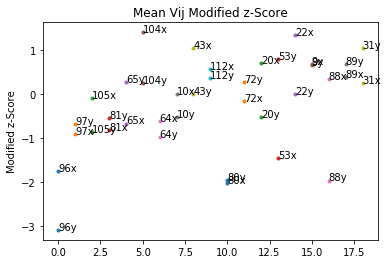

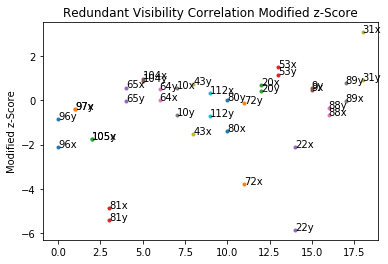

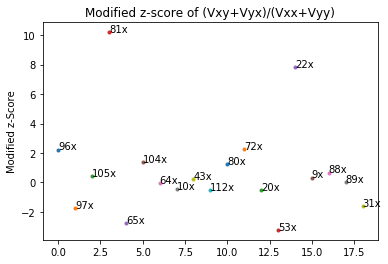

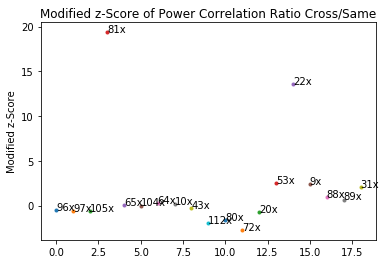

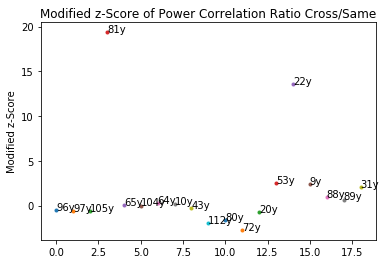

In [19]:
plt.figure()
plot_metric(ant_metrics['final_mod_z_scores']['meanVij'], 
            title = 'Mean Vij Modified z-Score')

plt.figure()
plot_metric(ant_metrics['final_mod_z_scores']['redCorr'],
            title = 'Redundant Visibility Correlation Modified z-Score')

plt.figure()
plot_metric(ant_metrics['final_mod_z_scores']['meanVijXPol'], antpols=['x'],
            title = 'Modified z-score of (Vxy+Vyx)/(Vxx+Vyy)')

plt.figure()
plot_metric(ant_metrics['final_mod_z_scores']['redCorrXPol'], antpols=['x'],
            title = 'Modified z-Score of Power Correlation Ratio Cross/Same')
plt.figure()
plot_metric(ant_metrics['final_mod_z_scores']['redCorrXPol'], antpols=['y'],
            title = 'Modified z-Score of Power Correlation Ratio Cross/Same')


In [ ]:
# append ant metrics over night
mets_xx = OrderedDict({'times':[],
                       'ant_phs_std_per_time':OrderedDict(map(lambda a: (a, []), ants)),
                       'chisq_avg':[]})
mets_yy = OrderedDict({'times':[],
                            'ant_phs_std_per_time':OrderedDict(map(lambda a: (a, []), ants)),
                            'chisq_avg':[]})

for i, (xxf, yyf) in enumerate(zip(xxfiles, yyfiles)):
    mets_xx = hqm.omnical_metrics.load_omnical_metrics(xxf+'.omni.calfits.omni_metrics.json')['XX']
    mets_yy = hqm.omnical_metrics.load_omnical_metrics(yyf+'.omni.calfits.omni_metrics.json')['YY']
    for a in ants:
        if a in mets_xx['ant_array']:
            full_mets_xx['ant_phs_std_per_time'][a].extend(mets_xx['ant_phs_std_per_time'][a])
        else:
            full_mets_xx['ant_phs_std_per_time'][a].extend(np.zeros(mets_xx['Ntimes']))
        if a in mets_yy['ant_array']:
            full_mets_yy['ant_phs_std_per_time'][a].extend(mets_yy['ant_phs_std_per_time'][a])
        else:
            full_mets_yy['ant_phs_std_per_time'][a].extend(np.zeros(mets_yy['Ntimes']))

    full_mets_xx['times'].extend(mets_xx['times'])
    full_mets_yy['times'].extend(mets_yy['times'])
    full_mets_xx['chisq_avg'].extend(mets_xx['chisq_avg'])
    full_mets_yy['chisq_avg'].extend(mets_yy['chisq_avg'])

In [ ]:
# plot each antenna gain phase stand dev over time
data = np.array(full_mets_xx['ant_phs_std_per_time'].values()).T

# figure
fig, ax = plt.subplots(1, figsize=(12,14))

# plotting
ymean = np.median(mets_xx['ant_phs_std'].values())
ysig = np.std(mets_xx['ant_phs_std'].values())
ymin = np.max([ymean-ysig*4, 0])
ymax = ymean+ysig*4
cax = ax.matshow(data, aspect='auto', cmap='Spectral', vmin=ymin, vmax=ymax,
                 extent=[0, Nants, full_mets_xx['times'][-1], full_mets_xx['times'][0]])

[t.set_rotation(20) for t in ax.get_xticklabels()]
[t.set_size(12) for t in ax.get_xticklabels()]
[t.set_rotation(20) for t in ax.get_yticklabels()]
[t.set_size(12) for t in ax.get_yticklabels()]

# axes
ax.xaxis.set_ticks_position('top')
ax.set_xticks(np.arange(Nants)+0.5)
ax.tick_params(size=8)
ax.set_xticklabels(ants)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.5f'))

ax.set_title("stand. dev of fc-subtracted gain phase over observation for XX pol", fontsize=14)
cbar = fig.colorbar(cax, fraction=0.05)
cbar.set_label('gain phase std [radians]', fontsize=14)
cbar.ax.tick_params(labelsize=12)

## Firstcal Solutions and Metrics

In [5]:
fcfiles_xx = map(lambda x: os.path.join(data_path, x + '.first.calfits'), xxfile_bases)
fcfiles_yy = map(lambda x: os.path.join(data_path, x + '.first.calfits'), yyfile_bases)

FC_xx = hqm.firstcal_metrics.FirstCal_Metrics(fcfiles_xx, use_gp=True)
FC_yy = hqm.firstcal_metrics.FirstCal_Metrics(fcfiles_yy, use_gp=True)

### Plot each Antenna's delay solution and its delay solution fluctuation over time

XX pol


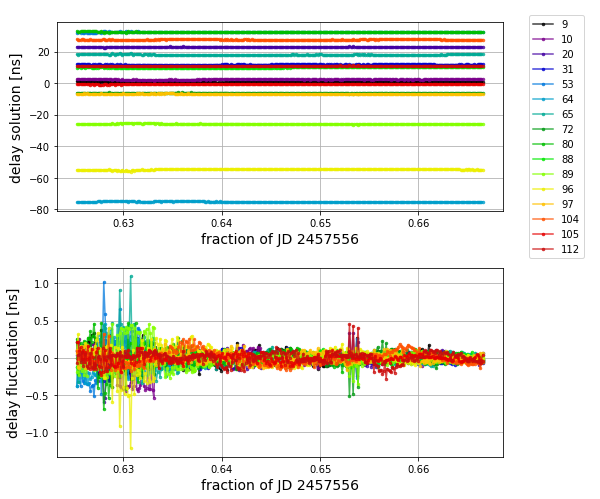

In [6]:
print "XX pol"
fig = FC_xx.plot_delays()

YY pol


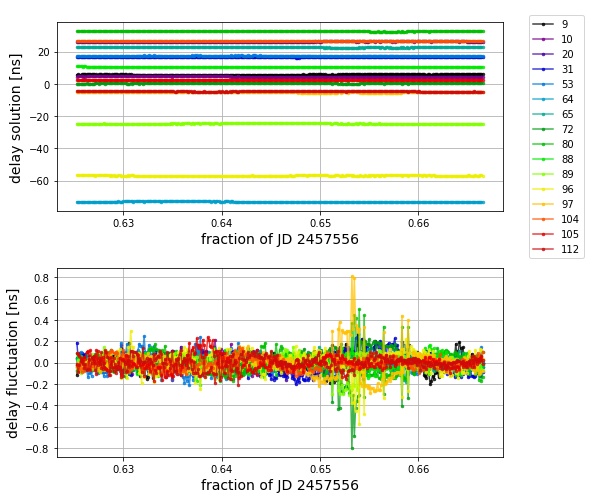

In [21]:
print "YY pol"
FC_yy.plot_delays()

### plot delay solution standard deviations for each antenna [nanosecs]
Threshold for "bad" solution is set to be a standard deviation $\ge$ 0.5 nanoseconds.

In [7]:
# append chisq metric across entire night
fc_met_xxfiles = map(lambda x: x + '.firstcal_metrics.json', fcfiles_xx)
fc_met_yyfiles = map(lambda x: x + '.firstcal_metrics.json', fcfiles_yy)

mets_xx = OrderedDict({'file_times':[],
                        'ant_dly_std':OrderedDict(map(lambda a: (a, []), ants)),
                        'good_sol':[]})
mets_yy = OrderedDict({'file_times':[],
                        'ant_dly_std':OrderedDict(map(lambda a: (a, []), ants)),
                        'good_sol':[]})

for i, (fc_met_xxfile, fc_met_yyfile) in enumerate(zip(fc_met_xxfiles, fc_met_yyfiles)):
    fc_xx_mets = hqm.firstcal_metrics.load_firstcal_metrics(fc_met_xxfile)
    fc_yy_mets = hqm.firstcal_metrics.load_firstcal_metrics(fc_met_yyfile)
    
    mets_xx['file_times'].append(float('.'.join(fc_xx_mets['fc_filestem'].split('.')[1:3])) % jd_start)
    mets_xx['good_sol'].append(fc_xx_mets['good_sol'])
    
    mets_yy['file_times'].append(float('.'.join(fc_yy_mets['fc_filestem'].split('.')[1:3])) % jd_start)
    mets_yy['good_sol'].append(fc_yy_mets['good_sol'])
    
    for a in ants:
        if a in fc_xx_mets['ants']:
            mets_xx['ant_dly_std'][a].append(fc_xx_mets['ant_std'][a])
        else:
            mets_xx['ant_dly_std'][a].append(0)
        if a in fc_yy_mets['ants']:
            mets_yy['ant_dly_std'][a].append(fc_yy_mets['ant_std'][a])
        else:
            mets_yy['ant_dly_std'][a].append(0)

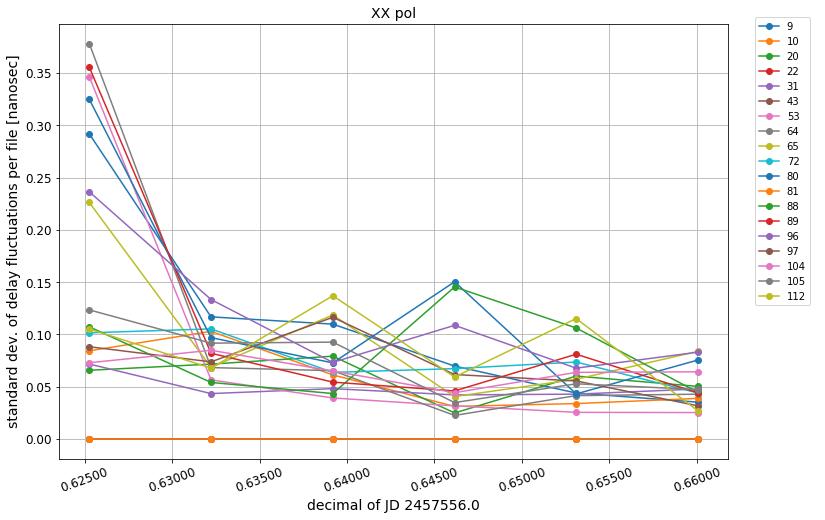

In [17]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.grid(True)

# plotting
p = map(lambda x: ax.plot(mets_xx['file_times'], x, marker='o', ls='-'), np.array(mets_xx['ant_dly_std'].values()))

# axes
ax.xaxis.set_major_formatter(FormatStrFormatter('%.5f'))
[t.set_rotation(20) for t in ax.get_xticklabels()]
[t.set_fontsize(12) for t in ax.get_xticklabels()]
[t.set_fontsize(12) for t in ax.get_yticklabels()]
ax.set_xlabel('decimal of JD {}'.format(jd_start), fontsize=14)
ax.set_ylabel('standard dev. of delay fluctuations per file [nanosec]', fontsize=14)
ax.set_title("XX pol", fontsize=14)
ax1 = fig.add_axes([0.95,0.1,0.05,0.8])
ax1.axis('off')
leg = ax1.legend(np.concatenate(p), ants)

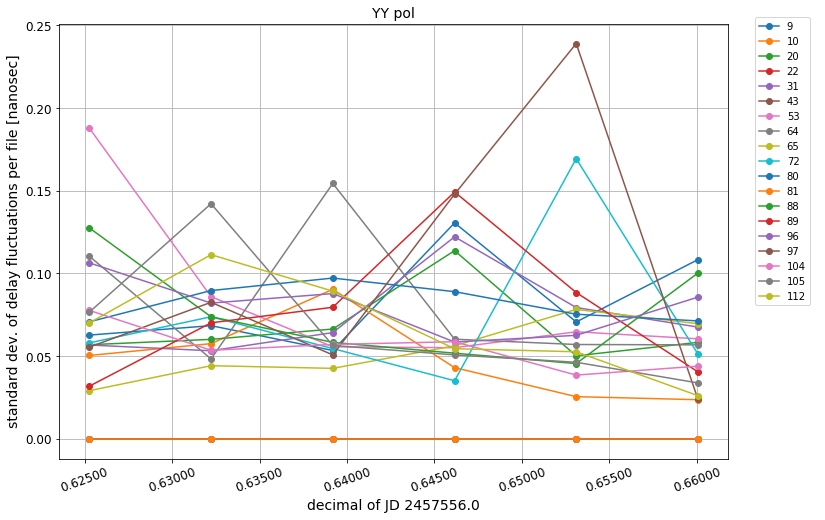

In [18]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.grid(True)

# plotting
p = map(lambda x: ax.plot(mets_yy['file_times'], x, marker='o', ls='-'), np.array(mets_yy['ant_dly_std'].values()))

# axes
ax.xaxis.set_major_formatter(FormatStrFormatter('%.5f'))
[t.set_rotation(20) for t in ax.get_xticklabels()]
[t.set_fontsize(12) for t in ax.get_xticklabels()]
[t.set_fontsize(12) for t in ax.get_yticklabels()]
ax.set_xlabel('decimal of JD {}'.format(jd_start), fontsize=14)
ax.set_ylabel('standard dev. of delay fluctuations per file [nanosec]', fontsize=14)
ax.set_title("YY pol", fontsize=14)
ax1 = fig.add_axes([0.95,0.1,0.05,0.8])
ax1.axis('off')
leg = ax1.legend(np.concatenate(p), ants)

## Omnical Solutions and Metrics

In [19]:
print "OmniCal Metrics for JD = {}".format(jd)

OmniCal Metrics for JD = 2457555.50099


In [20]:
# get files
ocfile_xx = os.path.join(data_path, xxfile_base + '.omni.calfits')
ocmodfile_xx = os.path.join(data_path, xxfile_base + '.vis.uvfits')
ocmetfile_xx = ocfile_xx + '.omni_metrics.json'
ocfile_yy = os.path.join(data_path, yyfile_base + '.omni.calfits')
ocmodfile_yy = os.path.join(data_path, yyfile_base + '.vis.uvfits')
ocmetfile_yy = ocfile_yy + '.omni_metrics.json'

# load omnical gain solutions and metrics
OM_xx = hqm.omnical_metrics.OmniCal_Metrics(ocfile_xx)
OM_yy = hqm.omnical_metrics.OmniCal_Metrics(ocfile_yy)
OM_xx.metrics = hqm.omnical_metrics.load_omnical_metrics(ocmetfile_xx)['XX']
OM_yy.metrics = hqm.omnical_metrics.load_omnical_metrics(ocmetfile_yy)['YY']
OM_xx.load_firstcal_gains(fcfile_xx)
OM_yy.load_firstcal_gains(fcfile_yy)

# load omnical model vis
uvom_xx = UVFITS()
uvom_xx.read_uvfits(ocmodfile_xx)
uvom_yy = UVFITS()
uvom_yy.read_uvfits(ocmodfile_yy)

In [21]:
# print good or bad sols
print "Good omnical phase stand. dev on XX pol :",OM_xx.metrics['ant_phs_std_good_sol']

Good omnical phase stand. dev on XX pol : True


In [22]:
# print good or bad sols
print "Good omnical phase std solution on YY pol :",OM_yy.metrics['ant_phs_std_good_sol']

Good omnical phase std solution on YY pol : True


### XX Antenna Gain Solutions for a single integration

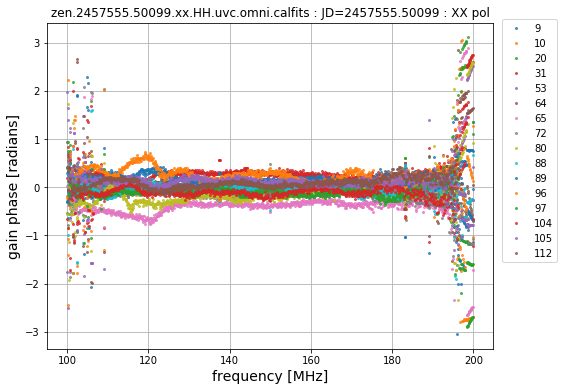

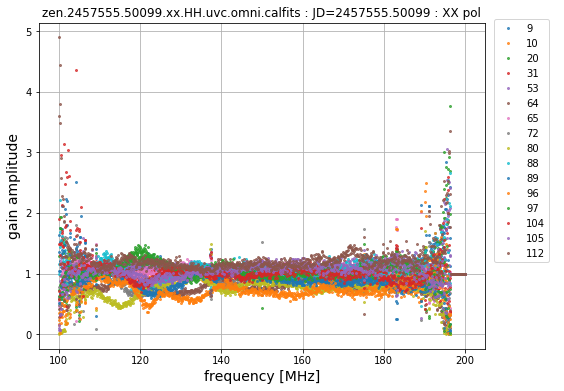

In [23]:
# look at XX gain solutions
OM_xx.plot_gains(divide_fc=True, plot_type='phs')
OM_xx.plot_gains(divide_fc=True, plot_type='amp')

### YY Antenna Gain Solutions for a single integration

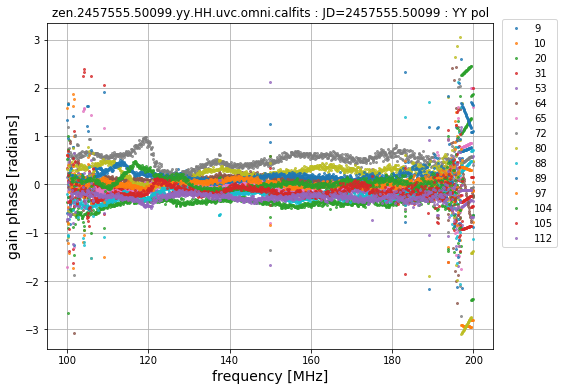

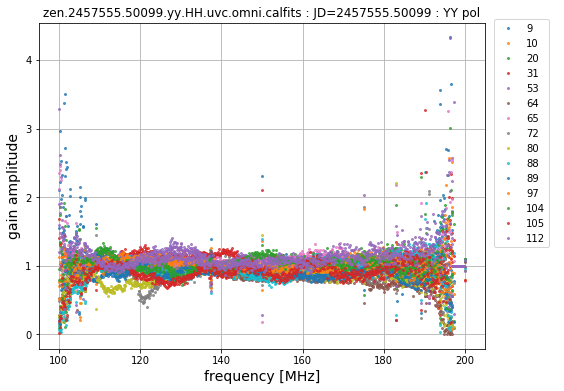

In [24]:
# look at YY gain solutions
OM_yy.plot_gains(divide_fc=True, plot_type='phs')
OM_yy.plot_gains(divide_fc=True, plot_type='amp')

### Omnical XX Metrics

Plot the standard deviation of the real-valued phase for each antenna. 

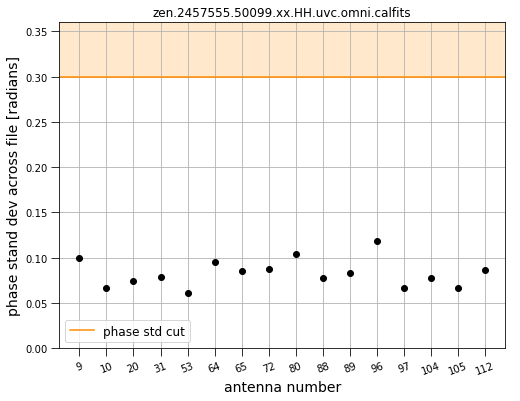

In [25]:
hqm.omnical_metrics.plot_phs_metric(OM_xx.metrics, plot_type='std')

Plot the delay spectrum of the gain solution for each antenna

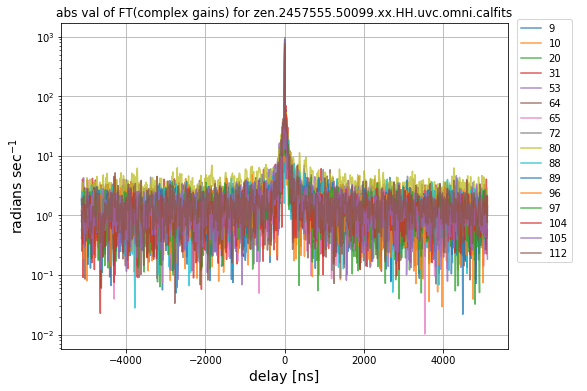

In [26]:
hqm.omnical_metrics.plot_phs_metric(OM_xx.metrics, plot_type='ft')

Plot the histogram of the gain solution after subtracting the median residual phase (after firstcal subtraction) for each antenna.

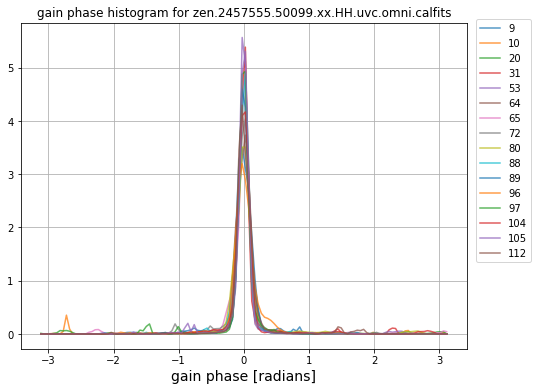

In [27]:
hqm.omnical_metrics.plot_phs_metric(OM_xx.metrics, plot_type='hist')

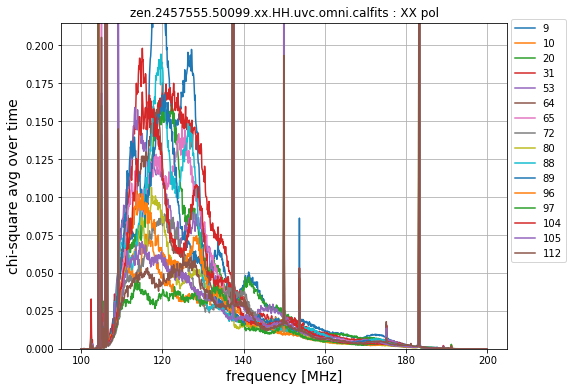

In [28]:
# look at xx time-averaged chisquare
OM_xx.plot_chisq_tavg()

### Omnical YY Metrics

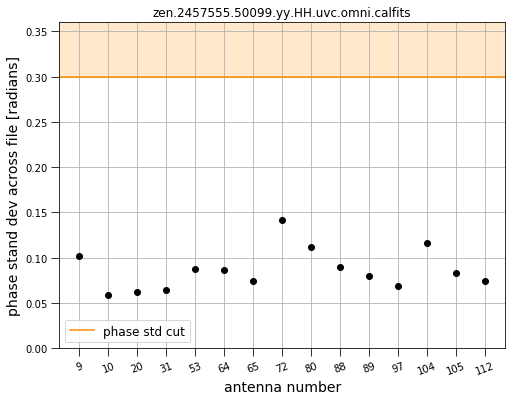

In [29]:
hqm.omnical_metrics.plot_phs_metric(OM_yy.metrics, plot_type='std')

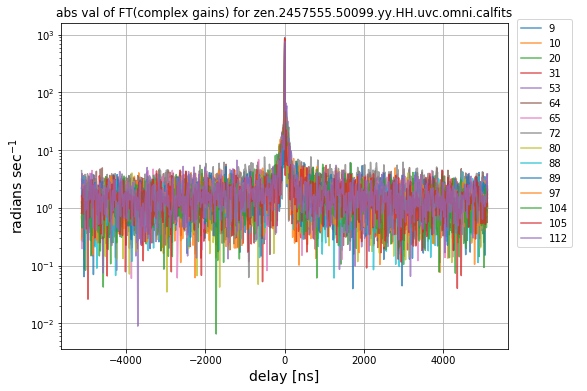

In [30]:
hqm.omnical_metrics.plot_phs_metric(OM_yy.metrics, plot_type='ft')

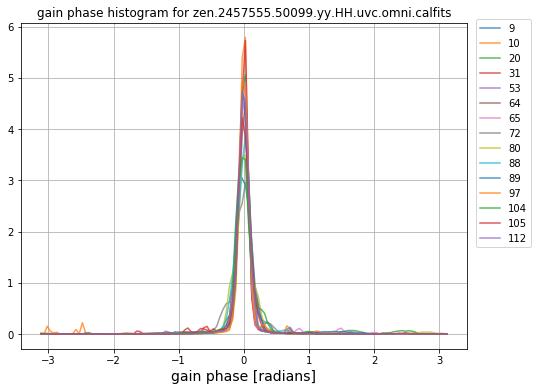

In [31]:
hqm.omnical_metrics.plot_phs_metric(OM_yy.metrics, plot_type='hist')

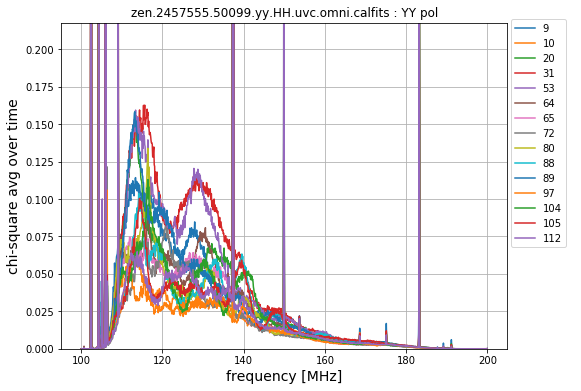

In [32]:
# look at yy time-averaged chisquare
OM_yy.plot_chisq_tavg()

## Plot omnical-applied visibility ratio waterfalls for a single redundant group

In [9]:
# load visibility data
uvd_xx = UVData()
uvd_xx.read_miriad(xxfile+'OR')
uvd_yy = UVData()
uvd_yy.read_miriad(yyfile+'OR')

In [10]:
# sort through bl groups with highest redundancy
Nredbls = np.array(map(lambda x: len(x), red_bls))
Nred_sort = np.argsort(Nredbls)[::-1]

# plot amplitude waterfalls for xx
i = 0
rbls = red_bls[Nred_sort[i]]
Nsp = Nredbls[Nred_sort[i]]
Nside = int(np.ceil(np.sqrt(Nsp)))
Yside = int(np.ceil(float(Nsp)/Nside))

not_great_ants = [21, 43, 88, 96]

# get reference bl
for bl in rbls:
    if bl[0] in not_great_ants or bl[1] in not_great_ants:
        continue
    else:
        refbl = bl
        break

NameError: name 'jd' is not defined

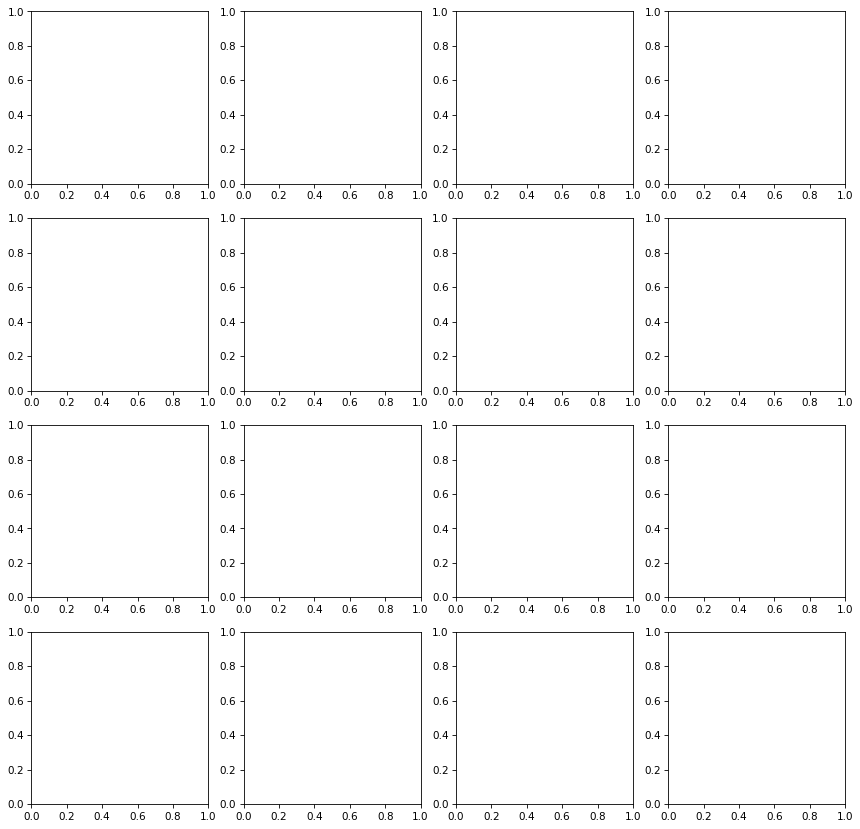

In [11]:
# plot amplitude waterfalls for xx
fig, axes = plt.subplots(Yside, Nside, figsize=(14,14), dpi=75)
fig.subplots_adjust(wspace=0.2, hspace=0.2)
fig.suptitle("omni-applied XX amplitude ratios to {0} for a single redundant group (JD = {1})".format(refbl, jd), fontsize=14)
fig.tight_layout(rect=(0, 0, 1, 0.95))

k = 0
for i in range(Yside):
    for j in range(Nside):
        ax = axes[i,j]
        plt.sca(ax)        
        if k < Nsp:
            uvt.plot.waterfall(uvd_xx.get_data(rbls[k])/uvd_xx.get_data(refbl), mode='log', mx=1, drng=2)
            ax.set_title(str(rbls[k]), fontsize=14)
        else:
            ax.axis('off')
        if k == Nsp-1:
            plt.colorbar(ax=ax, label='log amplitude')
        if j != 0:
            ax.set_yticklabels([])
        else:
            [t.set_fontsize(12) for t in ax.get_yticklabels()]
            ax.set_ylabel('time integrations', fontsize=14)
        if i != Yside-1:
            ax.set_xticklabels([])
        else:
            [t.set_fontsize(12) for t in ax.get_xticklabels()]
            ax.set_xlabel('freq channel', fontsize=14)

        k += 1

invalid value encountered in divide
divide by zero encountered in divide


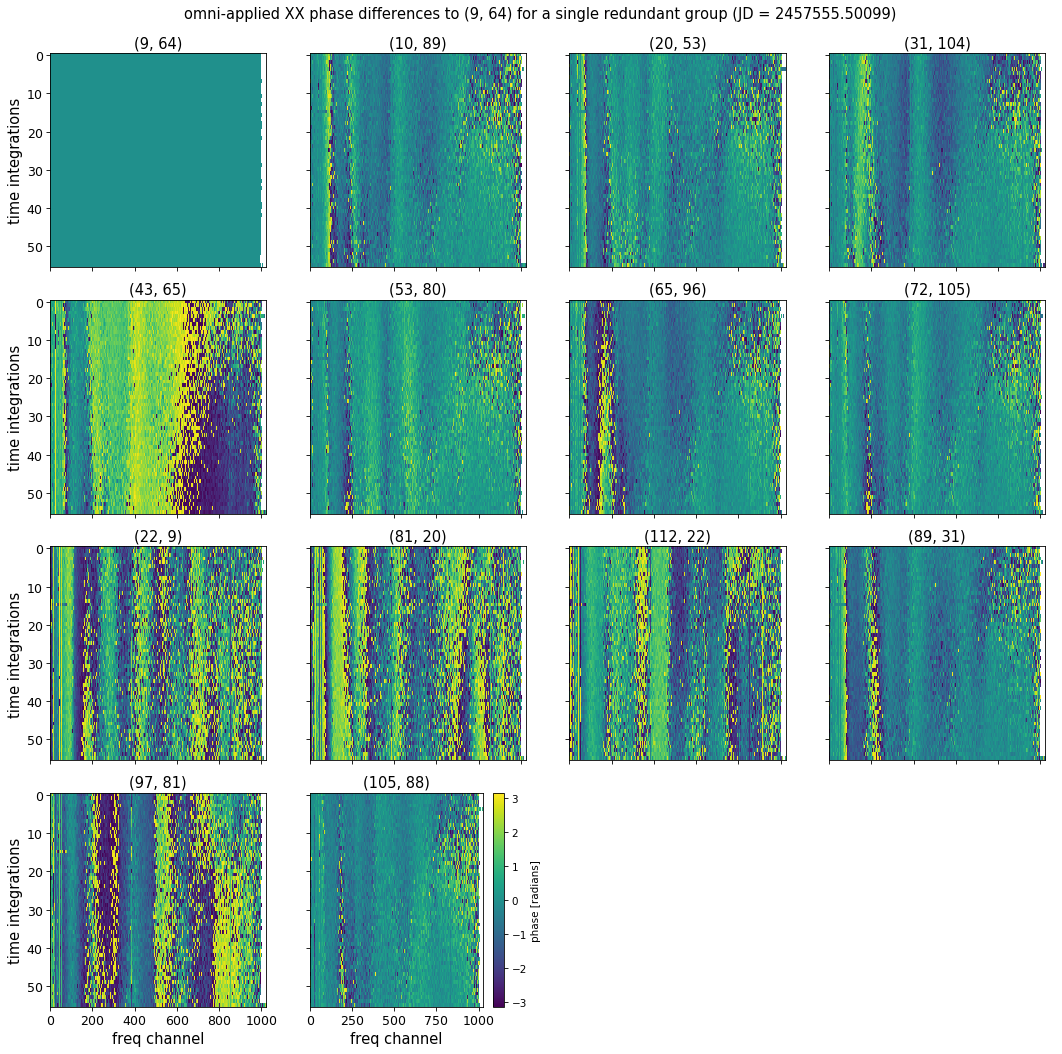

In [36]:
# plot phase waterfall for xx
fig, axes = plt.subplots(Yside, Nside, figsize=(14,14), dpi=75)
fig.subplots_adjust(wspace=0.2, hspace=0.2)
fig.suptitle("omni-applied XX phase differences to {0} for a single redundant group (JD = {1})".format(refbl, jd), fontsize=14)
fig.tight_layout(rect=(0, 0, 1, 0.95))

k = 0
for i in range(Yside):
    for j in range(Nside):
        ax = axes[i,j]
        plt.sca(ax)        
        if k < Nsp:
            uvt.plot.waterfall(uvd_xx.get_data(rbls[k])/uvd_xx.get_data(refbl), mode='phs', mx=np.pi, drng=2*np.pi)
            ax.set_title(str(rbls[k]), fontsize=14)
        else:
            ax.axis('off')
        if k == Nsp-1:
            plt.colorbar(ax=ax, label='phase [radians]')
        if j != 0:
            ax.set_yticklabels([])
        else:
            [t.set_fontsize(12) for t in ax.get_yticklabels()]
            ax.set_ylabel('time integrations', fontsize=14)
        if i != Yside-1:
            ax.set_xticklabels([])
        else:
            [t.set_fontsize(12) for t in ax.get_xticklabels()]
            ax.set_xlabel('freq channel', fontsize=14)

        k += 1

invalid value encountered in divide
divide by zero encountered in divide


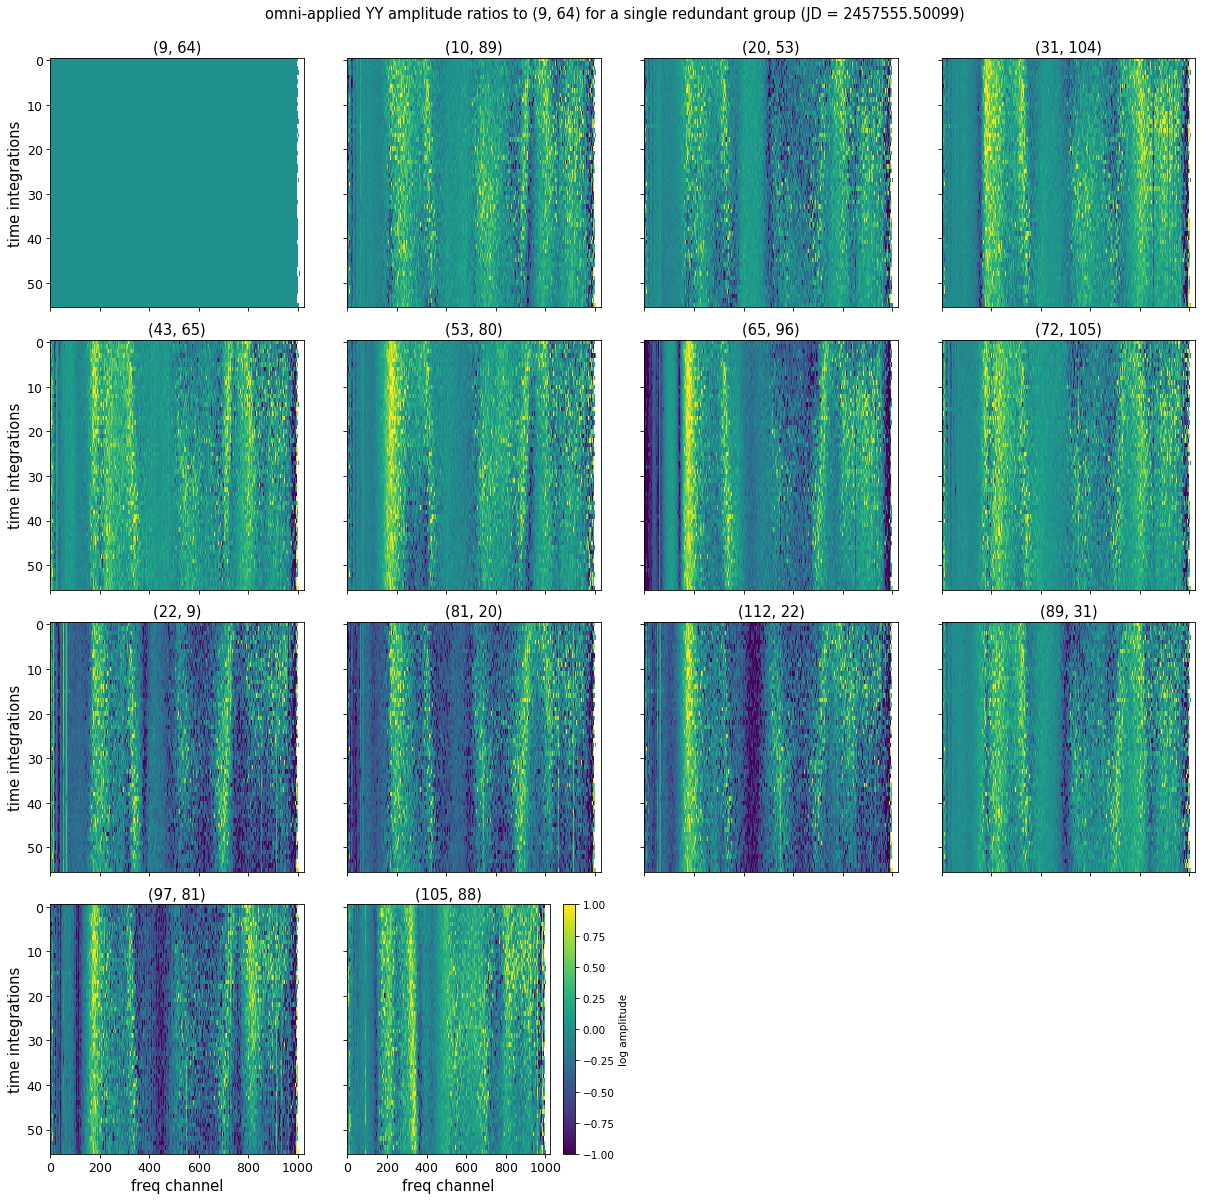

In [37]:
# plot amplitude waterfalls for yy
fig, axes = plt.subplots(Yside, Nside, figsize=(16,16), dpi=75)
fig.subplots_adjust(wspace=0.2, hspace=0.2)
fig.suptitle("omni-applied YY amplitude ratios to {0} for a single redundant group (JD = {1})".format(refbl, jd), fontsize=14)
fig.tight_layout(rect=(0, 0, 1, 0.95))

k = 0
for i in range(Yside):
    for j in range(Nside):
        ax = axes[i,j]
        plt.sca(ax)        
        if k < Nsp:
            uvt.plot.waterfall(uvd_yy.get_data(rbls[k])/uvd_yy.get_data(refbl), mode='log', mx=1, drng=2)
            ax.set_title(str(rbls[k]), fontsize=14)
        else:
            ax.axis('off')
        if k == Nsp-1:
            plt.colorbar(ax=ax, label='log amplitude')
        if j != 0:
            ax.set_yticklabels([])
        else:
            [t.set_fontsize(12) for t in ax.get_yticklabels()]
            ax.set_ylabel('time integrations', fontsize=14)
        if i != Yside-1:
            ax.set_xticklabels([])
        else:
            [t.set_fontsize(12) for t in ax.get_xticklabels()]
            ax.set_xlabel('freq channel', fontsize=14)

        k += 1

invalid value encountered in divide
divide by zero encountered in divide


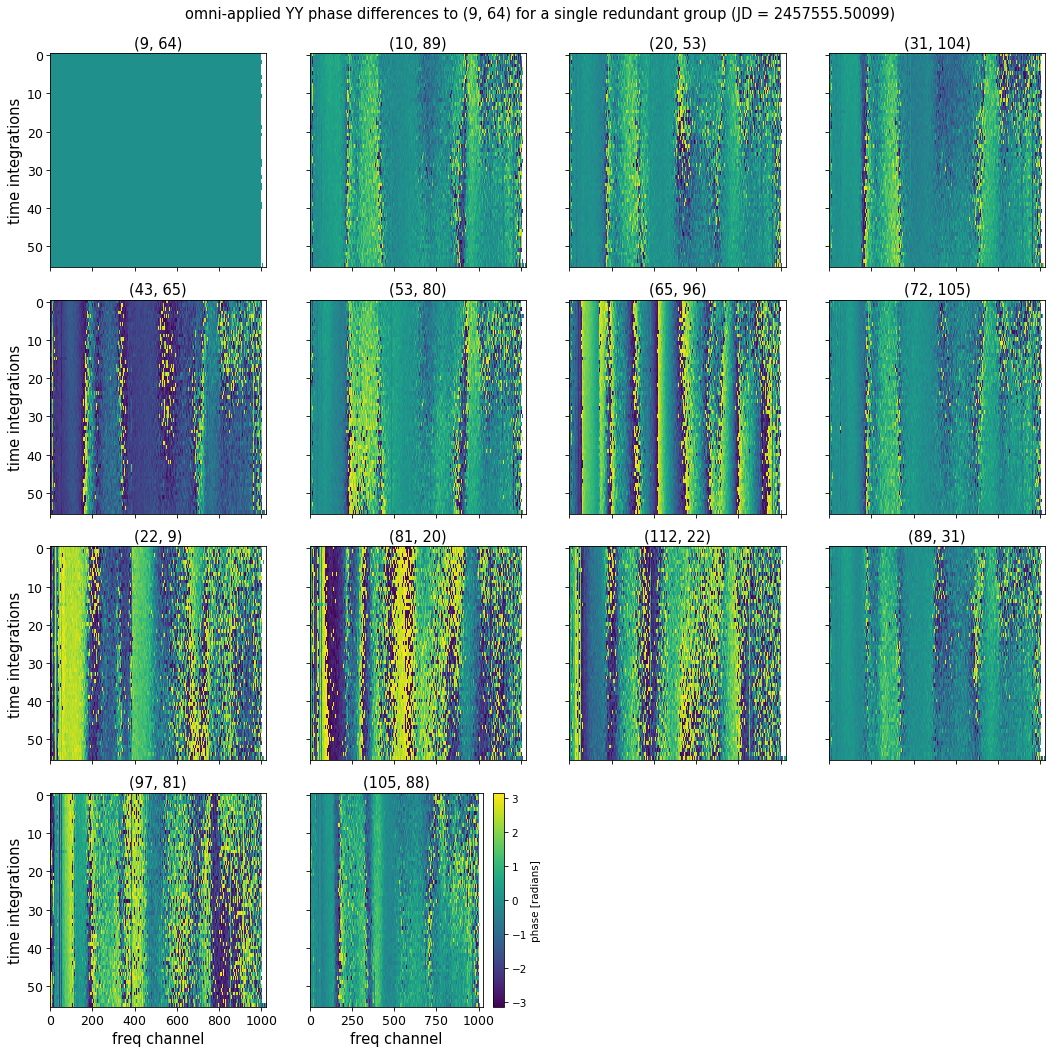

In [38]:
# plot phase waterfall for yy
fig, axes = plt.subplots(Yside, Nside, figsize=(14,14), dpi=75)
fig.subplots_adjust(wspace=0.2, hspace=0.2)
fig.suptitle("omni-applied YY phase differences to {0} for a single redundant group (JD = {1})".format(refbl, jd), fontsize=14)
fig.tight_layout(rect=(0, 0, 1, 0.95))

k = 0
for i in range(Yside):
    for j in range(Nside):
        ax = axes[i,j]
        plt.sca(ax)        
        if k < Nsp:
            uvt.plot.waterfall(uvd_yy.get_data(rbls[k])/uvd_yy.get_data(refbl), mode='phs', mx=np.pi, drng=2*np.pi)
            ax.set_title(str(rbls[k]), fontsize=14)
        else:
            ax.axis('off')
        if k == Nsp-1:
            plt.colorbar(ax=ax, label='phase [radians]')
        if j != 0:
            ax.set_yticklabels([])
        else:
            [t.set_fontsize(12) for t in ax.get_yticklabels()]
            ax.set_ylabel('time integrations', fontsize=14)
        if i != Yside-1:
            ax.set_xticklabels([])
        else:
            [t.set_fontsize(12) for t in ax.get_xticklabels()]
            ax.set_xlabel('freq channel', fontsize=14)

        k += 1

## Plot omnical metrics across the day

In [39]:
# append chisq metric across entire night
full_mets_xx = OrderedDict({'times':[],
                            'ant_phs_std_per_time':OrderedDict(map(lambda a: (a, []), ants)),
                            'chisq_avg':[]})
full_mets_yy = OrderedDict({'times':[],
                            'ant_phs_std_per_time':OrderedDict(map(lambda a: (a, []), ants)),
                            'chisq_avg':[]})

for i, (xxf, yyf) in enumerate(zip(xxfiles, yyfiles)):
    mets_xx = hqm.omnical_metrics.load_omnical_metrics(xxf+'.omni.calfits.omni_metrics.json')['XX']
    mets_yy = hqm.omnical_metrics.load_omnical_metrics(yyf+'.omni.calfits.omni_metrics.json')['YY']
    for a in ants:
        if a in mets_xx['ant_array']:
            full_mets_xx['ant_phs_std_per_time'][a].extend(mets_xx['ant_phs_std_per_time'][a])
        else:
            full_mets_xx['ant_phs_std_per_time'][a].extend(np.zeros(mets_xx['Ntimes']))
        if a in mets_yy['ant_array']:
            full_mets_yy['ant_phs_std_per_time'][a].extend(mets_yy['ant_phs_std_per_time'][a])
        else:
            full_mets_yy['ant_phs_std_per_time'][a].extend(np.zeros(mets_yy['Ntimes']))

    full_mets_xx['times'].extend(mets_xx['times'])
    full_mets_yy['times'].extend(mets_yy['times'])
    full_mets_xx['chisq_avg'].extend(mets_xx['chisq_avg'])
    full_mets_yy['chisq_avg'].extend(mets_yy['chisq_avg'])

### standard deviation of XX & YY gain phases over observation

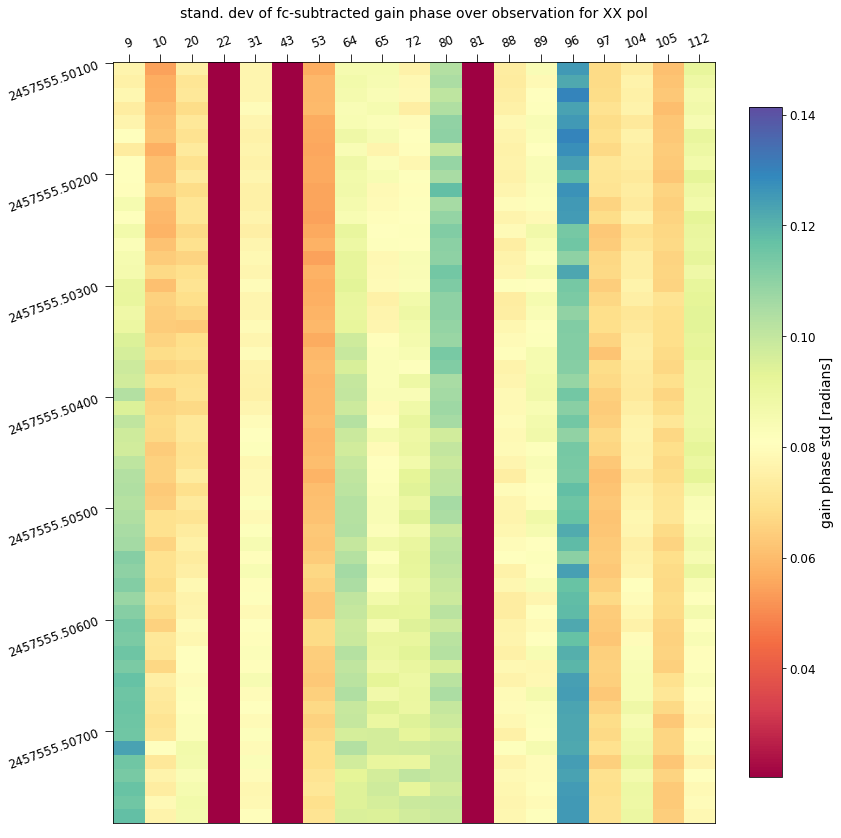

In [40]:
# plot each antenna gain phase stand dev over time
data = np.array(full_mets_xx['ant_phs_std_per_time'].values()).T

# figure
fig, ax = plt.subplots(1, figsize=(12,14))

# plotting
ymean = np.median(mets_xx['ant_phs_std'].values())
ysig = np.std(mets_xx['ant_phs_std'].values())
ymin = np.max([ymean-ysig*4, 0])
ymax = ymean+ysig*4
cax = ax.matshow(data, aspect='auto', cmap='Spectral', vmin=ymin, vmax=ymax,
                 extent=[0, Nants, full_mets_xx['times'][-1], full_mets_xx['times'][0]])

[t.set_rotation(20) for t in ax.get_xticklabels()]
[t.set_size(12) for t in ax.get_xticklabels()]
[t.set_rotation(20) for t in ax.get_yticklabels()]
[t.set_size(12) for t in ax.get_yticklabels()]

# axes
ax.xaxis.set_ticks_position('top')
ax.set_xticks(np.arange(Nants)+0.5)
ax.tick_params(size=8)
ax.set_xticklabels(ants)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.5f'))

ax.set_title("stand. dev of fc-subtracted gain phase over observation for XX pol", fontsize=14)
cbar = fig.colorbar(cax, fraction=0.05)
cbar.set_label('gain phase std [radians]', fontsize=14)
cbar.ax.tick_params(labelsize=12)

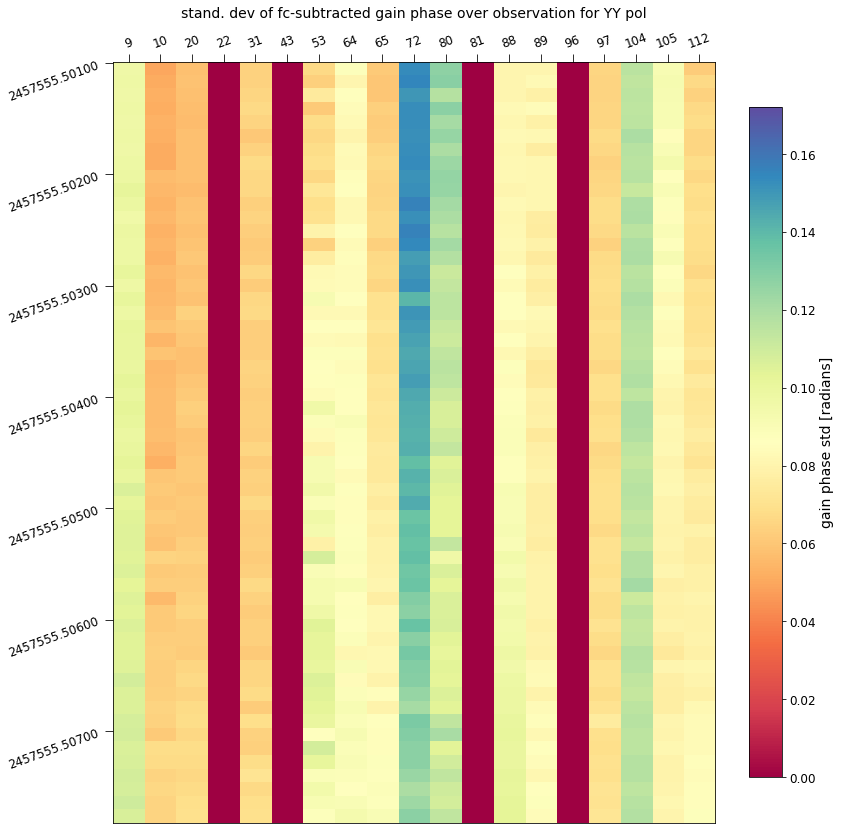

In [41]:
# plot each antenna gain phase stand dev over time
data = np.array(full_mets_yy['ant_phs_std_per_time'].values()).T

# figure
fig, ax = plt.subplots(1, figsize=(12,14))

# plotting
ymean = np.median(mets_yy['ant_phs_std'].values())
ysig = np.std(mets_yy['ant_phs_std'].values())
ymin = np.max([ymean-ysig*4, 0])
ymax = ymean+ysig*4
cax = ax.matshow(data, aspect='auto', cmap='Spectral', vmin=ymin, vmax=ymax,
                 extent=[0, Nants, full_mets_yy['times'][-1], full_mets_yy['times'][0]])

[t.set_rotation(20) for t in ax.get_xticklabels()]
[t.set_size(12) for t in ax.get_xticklabels()]
[t.set_rotation(20) for t in ax.get_yticklabels()]
[t.set_size(12) for t in ax.get_yticklabels()]

# axes
ax.xaxis.set_ticks_position('top')
ax.set_xticks(np.arange(Nants)+0.5)
ax.tick_params(size=8)
ax.set_xticklabels(ants)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.5f'))

ax.set_title("stand. dev of fc-subtracted gain phase over observation for YY pol", fontsize=14)
cbar = fig.colorbar(cax, fraction=0.05)
cbar.set_label('gain phase std [radians]', fontsize=14)
cbar.ax.tick_params(labelsize=12)

### Plot averaged omnical Chi-Square over entire observation 

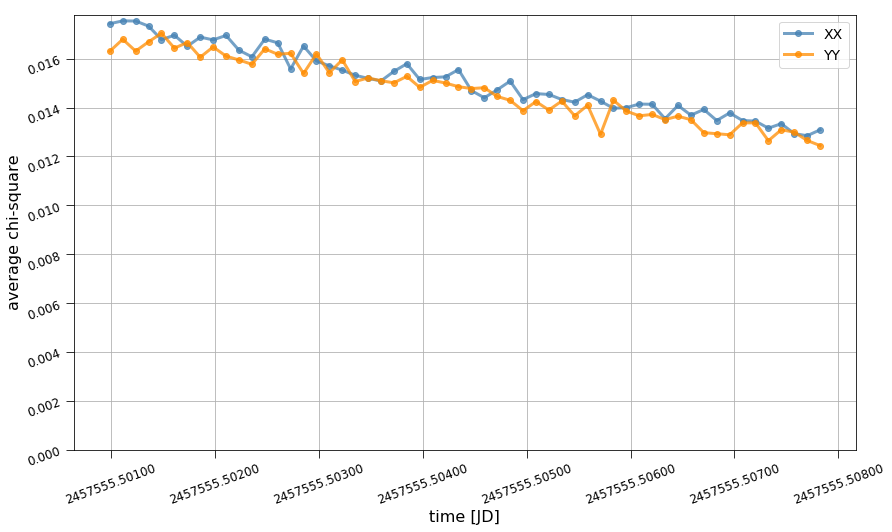

In [62]:
# figure
fig, ax = plt.subplots(1, figsize=(14,8))
ax.grid(True)

# plot
p1, = ax.plot(full_mets_xx['times'], full_mets_xx['chisq_avg'], color='steelblue', alpha=0.75, lw=3, marker='o')
p2, = ax.plot(full_mets_yy['times'], full_mets_yy['chisq_avg'], color='darkorange', alpha=0.75, lw=3, marker='o')
ax.legend([p1, p2], ['XX', 'YY'], fontsize=14)

# axes
ax.set_ylim(0, None)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.5f'))
[t.set_rotation(20) for t in ax.get_xticklabels()]
[t.set_size(12) for t in ax.get_xticklabels()]
[t.set_rotation(20) for t in ax.get_yticklabels()]
[t.set_size(12) for t in ax.get_yticklabels()]
ax.tick_params(size=8)
ax.set_xlabel('time [ JD ]', fontsize=16)
ax.set_ylabel('average chi-square', fontsize=16)